In [13]:
# ================================================================
# Project Limpyo: Otoscopic Image Analysis for Cerumen Impaction and Infection Risk Assessment
# A CSC173 Project: Computer Vision
# Lavigne Kaye S. Sistona
# ================================================================


# 1. IMPORT 


import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed
def set_seed(seed=50):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(50)

In [14]:
# 2. CHECK

print("CHECKING DATA STRUCTURE")
print("-" * 50)

data_path = Path("data/Otoscopic_Data")
    
#hm images
total_images = 0
for folder in ['Normal', 'Myringosclerosis', 'Chronic Otitis Media', 'Cerumen Impaction', 'Acute Otitis Media']:
    folder_path = data_path / folder
    if folder_path.exists():
        images = list(folder_path.glob("*"))
        total_images += len(images)
        print(f"  {folder}: {len(images)} images")

print(f"\n Total images: {total_images}")

os.makedirs("data/train", exist_ok=True)
os.makedirs("data/test", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

CHECKING DATA STRUCTURE
--------------------------------------------------
  Normal: 600 images
  Myringosclerosis: 600 images
  Chronic Otitis Media: 600 images
  Cerumen Impaction: 600 images
  Acute Otitis Media: 600 images

 Total images: 3000


In [15]:
# 3. DATA PREP
 
print("PREPARING DATASET")
print("-" * 50)

import shutil
from sklearn.model_selection import train_test_split

# map risk
class_mapping = {
    'Normal': 'low_risk',
    'Myringosclerosis': 'medium_risk',
    'Cerumen Impaction': 'high_risk',
    'Acute Otitis Media': 'high_risk',
    'Chronic Otitis Media': 'high_risk'
}

all_images = []
all_labels = []

for original_class, risk_class in class_mapping.items():
    class_path = data_path / original_class
    if class_path.exists():
        images = list(class_path.glob("*"))
        for img_path in images:
            all_images.append(img_path)
            all_labels.append(risk_class)

print(f"Collected {len(all_images)} images")

# 70% train, 15% validation and 15% test---------------------------------------------
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Split: {len(train_paths)} train, {len(val_paths)} validation, {len(test_paths)} test")
print(f"Percentages: Train={100*len(train_paths)/len(all_images):.1f}%, "
      f"Val={100*len(val_paths)/len(all_images):.1f}%, "
      f"Test={100*len(test_paths)/len(all_images):.1f}%")

# train/test folders---------------------------------------------------

for split_name in ['train', 'val', 'test']:
    for risk_class in ['low_risk', 'medium_risk', 'high_risk']:
        os.makedirs(f"data/{split_name}/{risk_class}", exist_ok=True)

print("Prepping training images...")
for img_path, label in zip(train_paths, train_labels):
    dest_path = Path(f"data/train/{label}") / img_path.name
    shutil.copy2(img_path, dest_path)

print("Prepping validation images...")
for img_path, label in zip(val_paths, val_labels):
    dest_path = Path(f"data/val/{label}") / img_path.name
    shutil.copy2(img_path, dest_path)

print("Prepping test images...")
for img_path, label in zip(test_paths, test_labels):
    dest_path = Path(f"data/test/{label}") / img_path.name
    shutil.copy2(img_path, dest_path)

print("Dataset okie...")

PREPARING DATASET
--------------------------------------------------
Collected 3000 images
Split: 2100 train, 450 validation, 450 test
Percentages: Train=70.0%, Val=15.0%, Test=15.0%
Prepping training images...
Prepping validation images...
Prepping test images...
Dataset okie...


CREATING DATASET
--------------------------------------------------
Train dataset: 2400 images
Validation dataset: 450 images
Test dataset: 754 images
Sample for training set:


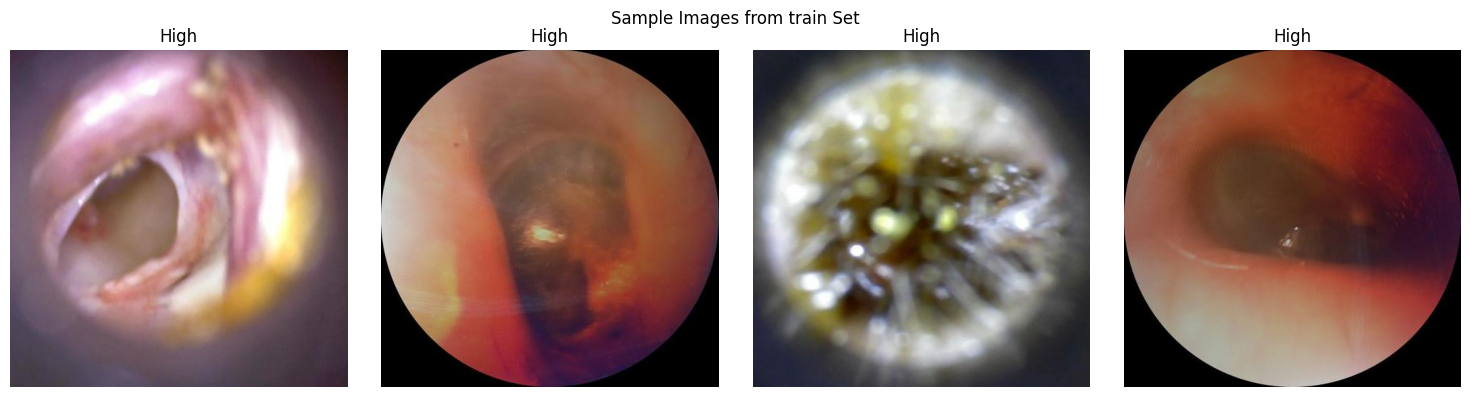

Sample for validation set:


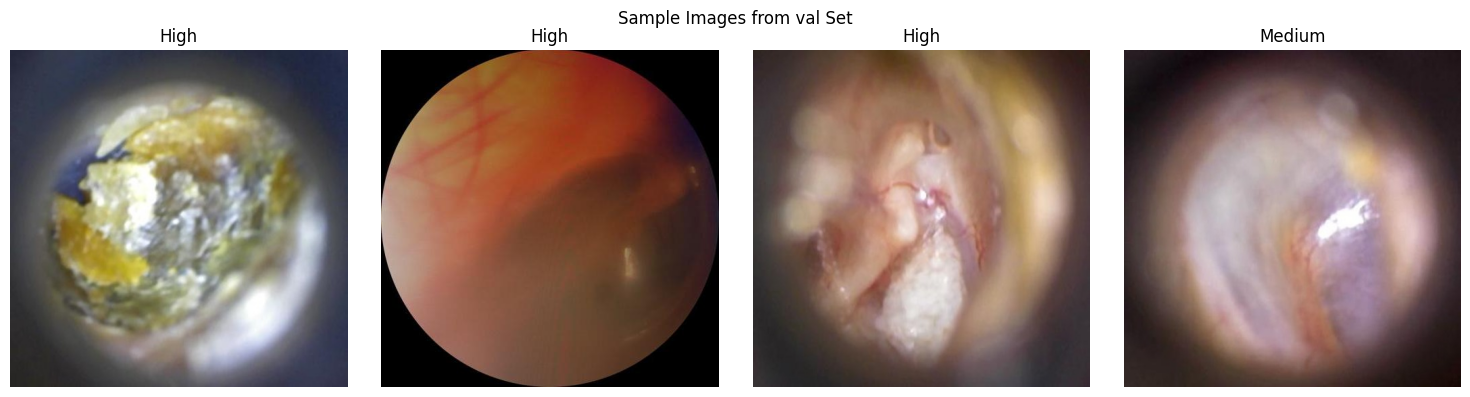

In [16]:
# 4. SIMPLE DATASET CLASS

print("CREATING DATASET")
print("-" * 50)

class SimpleEarDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        
        self.images = []
        self.labels = []
        
        # label mapping
        self.label_map = {'low_risk': 0, 'medium_risk': 1, 'high_risk': 2}
        
        for label_name, label_idx in self.label_map.items():
            class_dir = self.root_dir / label_name
            if class_dir.exists():
                images = list(class_dir.glob("*"))
                for img_path in images:
                    self.images.append(img_path)
                    self.labels.append(label_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        
        # transform?
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def show_samples(self, n=4):
        """Show sample images"""
        fig, axes = plt.subplots(1, n, figsize=(15, 4))
        
        indices = random.sample(range(len(self)), n)
        
        for idx, ax in enumerate(axes):
            img_path = self.images[indices[idx]]
            label = self.labels[indices[idx]]
            
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(['Low', 'Medium', 'High'][label])
            ax.axis('off')
        
        plt.suptitle(f"Sample Images from {self.root_dir.name} Set")
        plt.tight_layout()
        plt.show()

# defining transforms...
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# create datasets
train_dataset = SimpleEarDataset("data/train", transform=train_transform)
val_dataset = SimpleEarDataset("data/val", transform=val_test_transform)
test_dataset = SimpleEarDataset("data/test", transform=val_test_transform)

print(f"Train dataset: {len(train_dataset)} images")
print(f"Validation dataset: {len(val_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")

# exampol
print("Sample for training set:")
train_dataset.show_samples(4)

print("Sample for validation set:")
val_dataset.show_samples(4)

In [17]:
# 5. MODEL

print("CREATING MODEL")
print("-" * 50)

class SimpleCNN (nn.Module):
    """CNN with fewer parameters"""
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        
        # convolutional layers - dis wan detects patterns
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # pooling - dis wan looks at 2x2 pizel areas
        self.pool = nn.MaxPool2d(2, 2)
        
        # dropout - dis wan ignores some connection when training
        self.dropout = nn.Dropout(0.3)
        
        # fully connected layers - dis is where it assigned weights 
        self.fc1 = nn.Linear(64 * 16 * 16, 128) 
        self.fc2 = nn.Linear(128, num_classes)
        
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        
    def forward(self, x):
        # First conv block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Second conv block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Third conv block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten
        x = x.view(-1, 64 * 16 * 16)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def count_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total, trainable

# create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SimpleCNN(num_classes=3).to(device)

# count parameters
total_params, trainable_params = model.count_parameters()
print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")
print("Model created successfully yippie!")

CREATING MODEL
--------------------------------------------------
Using device: cpu
Model parameters: 2,121,475 total, 2,121,475 trainable
Model created successfully yippie!


In [18]:
# 6. TRAINING FUNCTION

print("TRAINING MODEL")
print("-" * 50)

def train_with_validation(model, train_dataset, val_dataset, test_dataset, epochs=10, batch_size=32):
    """Training function with separate validation set"""
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # learning rate 
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    # history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    print(f"Starting training for {epochs} epochs :)")
    print(f"Batch size: {batch_size}")
    print(f"Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    print("-" * 60)
    
    for epoch in range(epochs):
        # training phasee
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress 
        from tqdm import tqdm
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # update metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            current_loss = running_loss / (batch_idx + 1)
            current_acc = 100. * correct / total
            pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.2f}%'
            })
        
        # calculate the epoch metrics for training TT
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        
        # update scheduler
        scheduler.step()
        
        # save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # epoch summary
        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Training Loss: {train_loss:.4f} | "
              f"Training Accuracy: {train_acc:.2f}% | "
              f"Validation Loss: {val_loss:.4f} | "
              f"Validation Accuracy: {val_acc:.2f}% | "
              f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    print("Training Complete yippiee!!")
    
    # test evaluation
    test_loss, test_acc = evaluate_model(model, test_loader, criterion)
    print(f"FINAL TEST RESULTS:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    return history, model, test_acc

def evaluate_model(model, data_loader, criterion):
    """Evaluate model on any dataset"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(data_loader), 100. * correct / total

# train model
print("Waittt still training...")
history, trained_model, test_accuracy = train_with_validation(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=15,
    batch_size=32
)

TRAINING MODEL
--------------------------------------------------
Waittt still training...
Starting training for 15 epochs :)
Batch size: 32
Dataset sizes: Train=2400, Val=450, Test=754
------------------------------------------------------------


Epoch 1/15: 100%|██████████| 75/75 [00:48<00:00,  1.54it/s, loss=0.7815, acc=76.92%]


Epoch  1/15 | Training Loss: 0.7815 | Training Accuracy: 76.92% | Validation Loss: 0.2515 | Validation Accuracy: 91.11% | Learning Rate: 0.001000


Epoch 2/15: 100%|██████████| 75/75 [00:23<00:00,  3.19it/s, loss=0.2584, acc=89.67%]


Epoch  2/15 | Training Loss: 0.2584 | Training Accuracy: 89.67% | Validation Loss: 0.1504 | Validation Accuracy: 95.11% | Learning Rate: 0.001000


Epoch 3/15: 100%|██████████| 75/75 [00:24<00:00,  3.09it/s, loss=0.1935, acc=92.96%]


Epoch  3/15 | Training Loss: 0.1935 | Training Accuracy: 92.96% | Validation Loss: 0.1268 | Validation Accuracy: 95.56% | Learning Rate: 0.001000


Epoch 4/15: 100%|██████████| 75/75 [00:25<00:00,  2.98it/s, loss=0.1723, acc=92.96%]


Epoch  4/15 | Training Loss: 0.1723 | Training Accuracy: 92.96% | Validation Loss: 0.1247 | Validation Accuracy: 95.78% | Learning Rate: 0.001000


Epoch 5/15: 100%|██████████| 75/75 [00:31<00:00,  2.41it/s, loss=0.1293, acc=95.12%]


Epoch  5/15 | Training Loss: 0.1293 | Training Accuracy: 95.12% | Validation Loss: 0.0673 | Validation Accuracy: 98.00% | Learning Rate: 0.000500


Epoch 6/15: 100%|██████████| 75/75 [00:25<00:00,  2.97it/s, loss=0.0999, acc=96.25%]


Epoch  6/15 | Training Loss: 0.0999 | Training Accuracy: 96.25% | Validation Loss: 0.0847 | Validation Accuracy: 96.22% | Learning Rate: 0.000500


Epoch 7/15: 100%|██████████| 75/75 [00:26<00:00,  2.81it/s, loss=0.0771, acc=97.54%]


Epoch  7/15 | Training Loss: 0.0771 | Training Accuracy: 97.54% | Validation Loss: 0.0329 | Validation Accuracy: 98.44% | Learning Rate: 0.000500


Epoch 8/15: 100%|██████████| 75/75 [00:27<00:00,  2.71it/s, loss=0.0650, acc=97.58%]


Epoch  8/15 | Training Loss: 0.0650 | Training Accuracy: 97.58% | Validation Loss: 0.0289 | Validation Accuracy: 98.89% | Learning Rate: 0.000500


Epoch 9/15: 100%|██████████| 75/75 [00:29<00:00,  2.55it/s, loss=0.0683, acc=97.71%]


Epoch  9/15 | Training Loss: 0.0683 | Training Accuracy: 97.71% | Validation Loss: 0.0474 | Validation Accuracy: 98.00% | Learning Rate: 0.000500


Epoch 10/15: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s, loss=0.0582, acc=98.04%]


Epoch 10/15 | Training Loss: 0.0582 | Training Accuracy: 98.04% | Validation Loss: 0.0379 | Validation Accuracy: 98.89% | Learning Rate: 0.000250


Epoch 11/15: 100%|██████████| 75/75 [00:32<00:00,  2.33it/s, loss=0.0449, acc=98.46%]


Epoch 11/15 | Training Loss: 0.0449 | Training Accuracy: 98.46% | Validation Loss: 0.0153 | Validation Accuracy: 99.78% | Learning Rate: 0.000250


Epoch 12/15: 100%|██████████| 75/75 [00:29<00:00,  2.55it/s, loss=0.0363, acc=98.83%]


Epoch 12/15 | Training Loss: 0.0363 | Training Accuracy: 98.83% | Validation Loss: 0.0112 | Validation Accuracy: 99.78% | Learning Rate: 0.000250


Epoch 13/15: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s, loss=0.0290, acc=99.08%]


Epoch 13/15 | Training Loss: 0.0290 | Training Accuracy: 99.08% | Validation Loss: 0.0115 | Validation Accuracy: 99.78% | Learning Rate: 0.000250


Epoch 14/15: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s, loss=0.0324, acc=99.04%]


Epoch 14/15 | Training Loss: 0.0324 | Training Accuracy: 99.04% | Validation Loss: 0.0111 | Validation Accuracy: 99.78% | Learning Rate: 0.000250


Epoch 15/15: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s, loss=0.0442, acc=98.58%]


Epoch 15/15 | Training Loss: 0.0442 | Training Accuracy: 98.58% | Validation Loss: 0.0124 | Validation Accuracy: 99.78% | Learning Rate: 0.000125
Training Complete yippiee!!
FINAL TEST RESULTS:
Test Loss: 0.0118
Test Accuracy: 99.73%


VISUALIZING TRAINING RESULTS
--------------------------------------------------


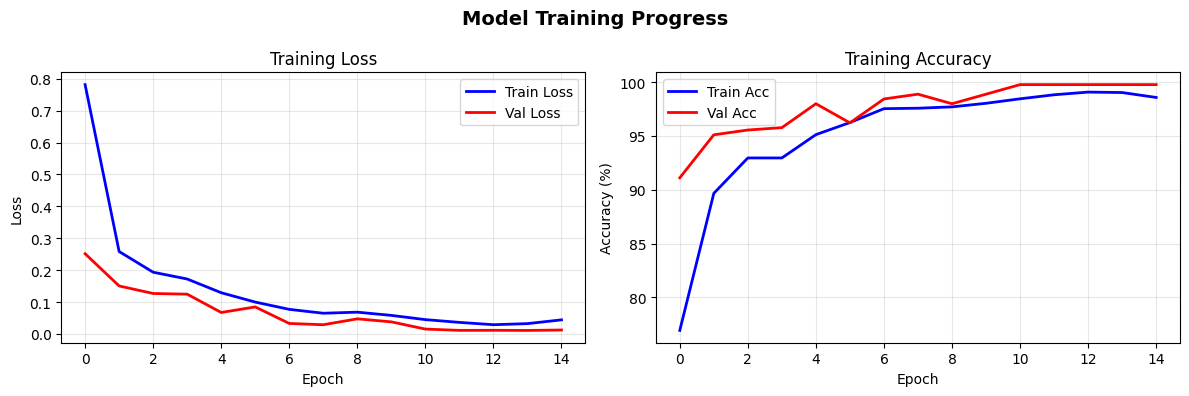


FINAL RESULTS:
----------------------------------------
Final Training Accuracy: 98.58%
Final Validation Accuracy: 99.78%
Best Validation Accuracy: 99.78%


In [19]:
# 7. VISUALIZE TRAINING RESULTS

print("VISUALIZING TRAINING RESULTS")
print("-" * 50)

# visualization eme
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
axes[0].plot(history['train_loss'], 'b-', linewidth=2, label='Train Loss')
axes[0].plot(history['val_loss'], 'r-', linewidth=2, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], 'b-', linewidth=2, label='Train Acc')
axes[1].plot(history['val_acc'], 'r-', linewidth=2, label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Model Training Progress', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/training_progress.png', dpi=100)
plt.show()


print("\nFINAL RESULTS:")
print("-" * 40)
print(f"Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")

EVALUATING MODEL
--------------------------------------------------
Test Accuracy: 99.73%
Test Samples: 754
Classification Report:
----------------------------------------
              precision    recall  f1-score   support

    Low Risk      1.000     0.986     0.993       147
 Medium Risk      0.987     1.000     0.994       156
   High Risk      1.000     1.000     1.000       451

    accuracy                          0.997       754
   macro avg      0.996     0.995     0.996       754
weighted avg      0.997     0.997     0.997       754



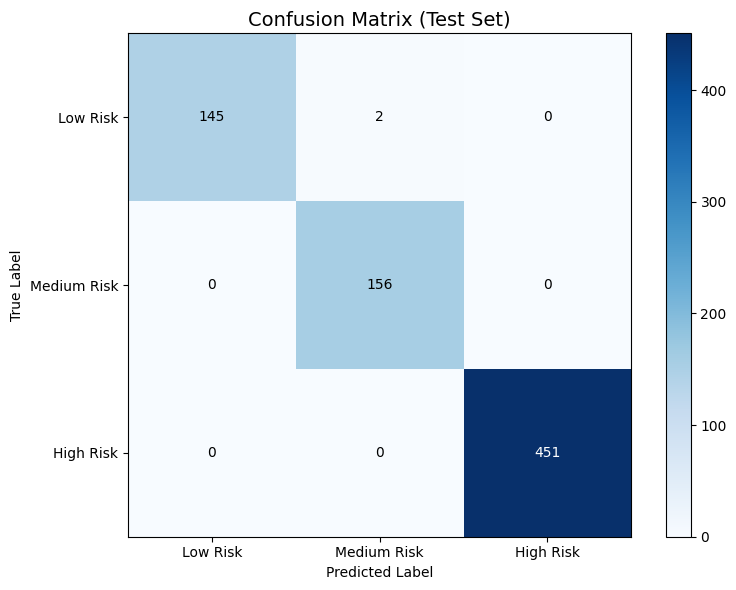

In [20]:
# # 8. EVALUATE MODEL

print("EVALUATING MODEL")
print("-" * 50)

def test_model(model, test_dataset):
    """Test model and show results"""
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # calculate accuracy
    accuracy = 100. * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Samples: {len(all_labels)}")
    
    # classification report
    print("Classification Report:")
    print("-" * 40)
    class_names = ['Low Risk', 'Medium Risk', 'High Risk']
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))
    
    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Test Set)', fontsize=14)
    plt.colorbar()
    
    # text for wow
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0, 1, 2], class_names)
    plt.yticks([0, 1, 2], class_names)
    
    plt.tight_layout()
    plt.savefig('results/confusion_matrix.png', dpi=100)
    plt.show()
    
    return accuracy, all_preds, all_labels

# run eval
accuracy, predictions, true_labels = test_model(trained_model, test_dataset)

MAKING PREDICTIONS
--------------------------------------------------
Model saved to 'models/simple_ear_model.pth'

Testing on sample images...

Analyzing: norm (10).jpg


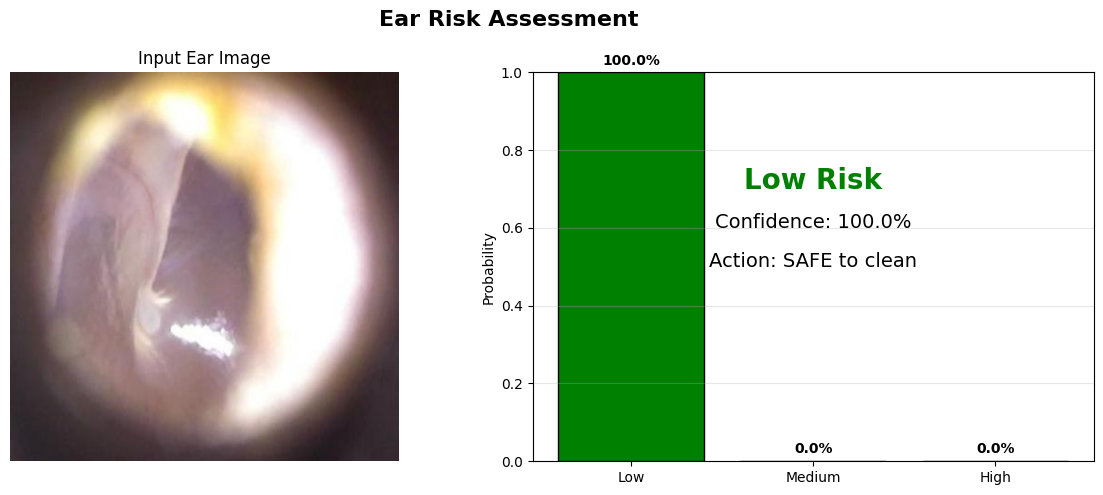

Prediction Result:
  Risk Level: Low Risk
  Confidence: 100.0%
  Recommended Action: SAFE to clean
  Probabilities: Low=100.0%, Medium=0.0%, High=0.0%

Analyzing: mys (105).jpg


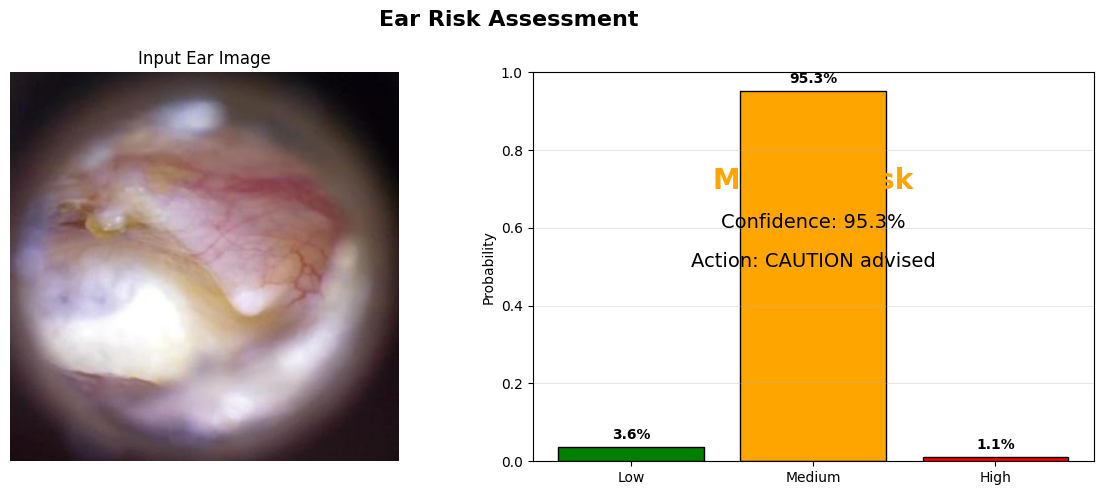

Prediction Result:
  Risk Level: Medium Risk
  Confidence: 95.3%
  Recommended Action: CAUTION advised
  Probabilities: Low=3.6%, Medium=95.3%, High=1.1%

Analyzing: aom (1).jpg


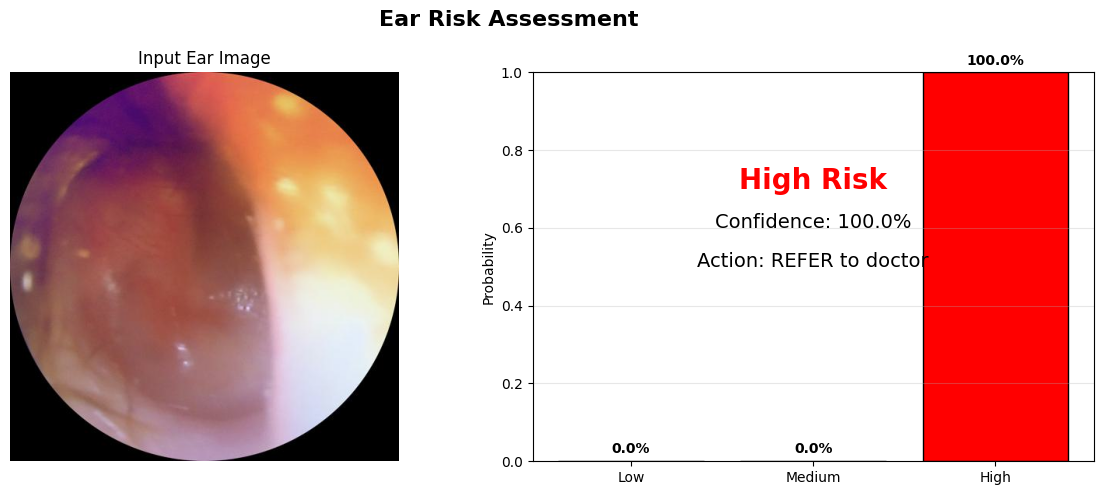

Prediction Result:
  Risk Level: High Risk
  Confidence: 100.0%
  Recommended Action: REFER to doctor
  Probabilities: Low=0.0%, Medium=0.0%, High=100.0%


In [21]:
# 9. PREDICT ON NEW IMAGES 

print("MAKING PREDICTIONS")
print("-" * 50)

class Predictor:
    """lets check kung gumana ba huhu"""
    def __init__(self, model_path=None):
        if model_path and Path(model_path).exists():
            self.model = SimpleCNN(num_classes=3)
            self.model.load_state_dict(torch.load(model_path, map_location=device))
        else:
            self.model = trained_model
        
        self.model.to(device)
        self.model.eval()
        
        # Transformation for prediction
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        
        self.risk_info = {
            0: {'name': 'Low Risk', 'color': 'green', 'action': 'SAFE to clean'},
            1: {'name': 'Medium Risk', 'color': 'orange', 'action': 'CAUTION advised'},
            2: {'name': 'High Risk', 'color': 'red', 'action': 'REFER to doctor'}
        }
    
    def predict(self, image_path):
        """Predict risk level for an image"""
        try:
            image = Image.open(image_path).convert('RGB')
            
            # Transform
            input_tensor = self.transform(image).unsqueeze(0).to(device)
            
            # Predict
            with torch.no_grad():
                output = self.model(input_tensor)
                probabilities = F.softmax(output, dim=1)
                pred_class = torch.argmax(output, dim=1).item()
                confidence = probabilities[0][pred_class].item()
            
            info = self.risk_info[pred_class]
            
            return {
                'class': pred_class,
                'name': info['name'],
                'confidence': confidence,
                'action': info['action'],
                'color': info['color'],
                'probabilities': probabilities[0].cpu().numpy(),
                'image': image
            }
        except Exception as e:
            print(f"Error predicting image: {e}")
            return None
    
    def show_prediction(self, image_path):
        """Show prediction with visualization"""
        result = self.predict(image_path)
        
        if result is None:
            print("Failed to predict image")
            return None
        
        # visualization para wow
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.imshow(result['image'])
        ax1.set_title('Input Ear Image')
        ax1.axis('off')
        
        ax2.text(0.5, 0.7, result['name'], fontsize=20, fontweight='bold',
                color=result['color'], ha='center', transform=ax2.transAxes)
        ax2.text(0.5, 0.6, f"Confidence: {result['confidence']:.1%}", fontsize=14,
                ha='center', transform=ax2.transAxes)
        ax2.text(0.5, 0.5, f"Action: {result['action']}", fontsize=14,
                ha='center', transform=ax2.transAxes)
        
        classes = ['Low', 'Medium', 'High']
        colors = ['green', 'orange', 'red']
        x_pos = np.arange(len(classes))
        
        ax2.bar(x_pos, result['probabilities'], color=colors, edgecolor='black')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(classes)
        ax2.set_ylabel('Probability')
        ax2.set_ylim(0, 1)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # probability values ni sha
        for i, prob in enumerate(result['probabilities']):
            ax2.text(i, prob + 0.02, f'{prob:.1%}', ha='center', fontweight='bold')
        
        ax2.axis('on')
        plt.suptitle('Ear Risk Assessment', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # resultz
        print(f"Prediction Result:")
        print(f"  Risk Level: {result['name']}")
        print(f"  Confidence: {result['confidence']:.1%}")
        print(f"  Recommended Action: {result['action']}")
        print(f"  Probabilities: Low={result['probabilities'][0]:.1%}, "
              f"Medium={result['probabilities'][1]:.1%}, "
              f"High={result['probabilities'][2]:.1%}")
        
        return result

# Save the trained model
torch.save(trained_model.state_dict(), 'models/simple_ear_model.pth')
print("Model saved to 'models/simple_ear_model.pth'")

# create predictor
predictor = Predictor()

# Test 
print("\nTesting on sample images...")
test_images = []

for risk_class in ['low_risk', 'medium_risk', 'high_risk']:
    test_dir = Path(f"data/test/{risk_class}")
    images = list(test_dir.glob("*"))
    if images:
        test_images.append(images[0])

# make predictions
if test_images:
    for img_path in test_images[:5]:  
        print(f"\nAnalyzing: {img_path.name}")
        predictor.show_prediction(img_path)
else:
    print("No test images found for prediction demo")

PROJECT SUMMARY
--------------------------------------------------


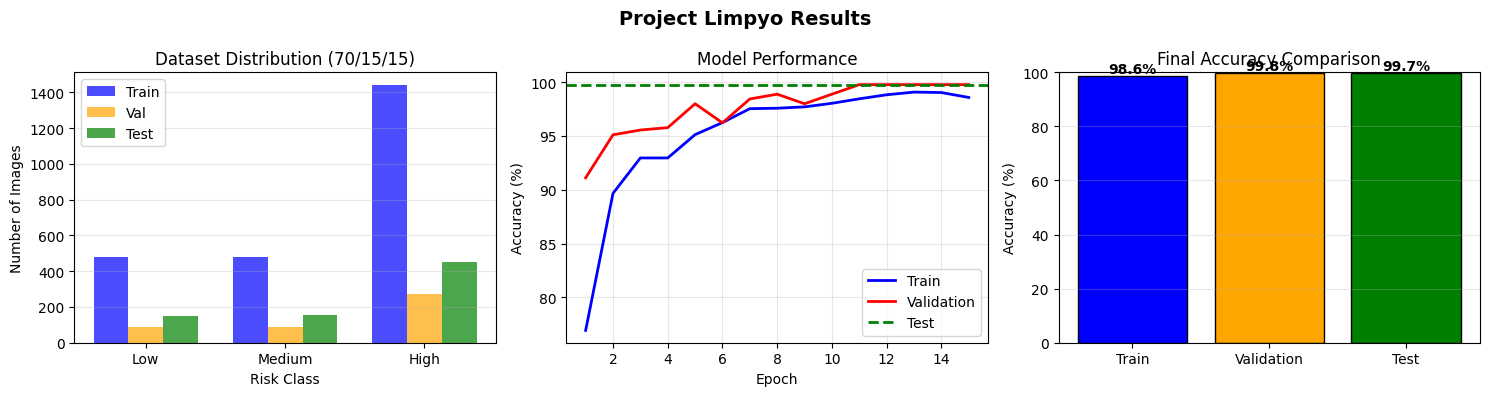

DATASET STATISTICS:
--------------------------------------------------
Total images: 3604
Training images: 2400 (70%)
Validation images: 450 (15%)
Testing images: 754 (15%)

  
MODEL PERFORMANCE:
--------------------------------------------------
Final Training Accuracy: 98.58%
Final Validation Accuracy: 99.78%
Test Accuracy: 99.73%
Best Validation Accuracy: 99.78%
Ready to use finally yippieee!!!


In [22]:
# 10. FINAL SUMMARY

print("PROJECT SUMMARY")
print("-" * 50)

# calculate class distribution
train_counts = []
val_counts = []
test_counts = []

for risk_class in ['low_risk', 'medium_risk', 'high_risk']:
    train_dir = Path(f"data/train/{risk_class}")
    val_dir = Path(f"data/val/{risk_class}")
    test_dir = Path(f"data/test/{risk_class}")
    
    train_count = len(list(train_dir.glob("*"))) if train_dir.exists() else 0
    val_count = len(list(val_dir.glob("*"))) if val_dir.exists() else 0
    test_count = len(list(test_dir.glob("*"))) if test_dir.exists() else 0
    
    train_counts.append(train_count)
    val_counts.append(val_count)
    test_counts.append(test_count)


# summary plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

#DISTRIBUTION ------------------------------------------------------------------
# 1. dataset
labels = ['Low', 'Medium', 'High']
x = np.arange(3)
width = 0.25

axes[0].bar(x - width, train_counts, width, label='Train', color='blue', alpha=0.7)
axes[0].bar(x, val_counts, width, label='Val', color='orange', alpha=0.7)
axes[0].bar(x + width, test_counts, width, label='Test', color='green', alpha=0.7)
axes[0].set_xlabel('Risk Class')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Dataset Distribution (70/15/15)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# 2. training/validation accuracy
epochs = range(1, len(history['train_acc']) + 1)
axes[1].plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2)
axes[1].axhline(y=accuracy, color='g', linestyle='--', label='Test', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Model Performance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. accuracy comparison
acc_values = [history['train_acc'][-1], history['val_acc'][-1], accuracy]
acc_labels = ['Train', 'Validation', 'Test']
colors = ['blue', 'orange', 'green']

bars = axes[2].bar(acc_labels, acc_values, color=colors, edgecolor='black')
axes[2].set_title('Final Accuracy Comparison')
axes[2].set_ylabel('Accuracy (%)')
axes[2].set_ylim(0, 100)
axes[2].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(acc_values):
    axes[2].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')


#------------------------------------------------------------

plt.suptitle('Project Limpyo Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/summary.png', dpi=100)
plt.show()


#SUMMARY
print("DATASET STATISTICS:")
print("-" * 50)
print(f"Total images: {sum(train_counts) + sum(val_counts) + sum(test_counts)}")
print(f"Training images: {sum(train_counts)} (70%)")
print(f"Validation images: {sum(val_counts)} (15%)")
print(f"Testing images: {sum(test_counts)} (15%)")

print("\n  ")
print("MODEL PERFORMANCE:")
print("-" * 50)
print(f"Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")

print("Ready to use finally yippieee!!!")



In [25]:
predictor = Predictor('models/simple_ear_model.pth')
print("oks nani, try predicting nahh!")

oks nani, try predicting nahh!


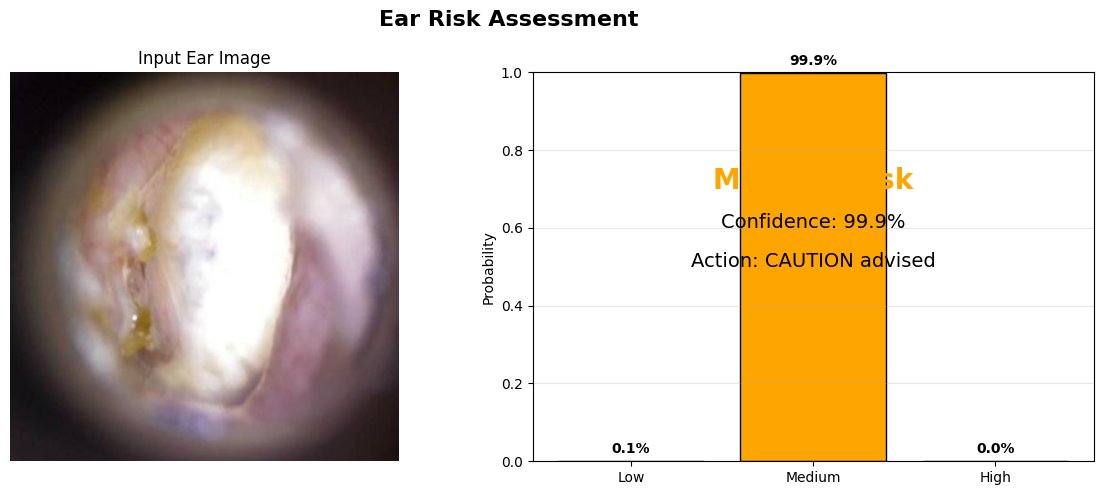

Prediction Result:
  Risk Level: Medium Risk
  Confidence: 99.9%
  Recommended Action: CAUTION advised
  Probabilities: Low=0.1%, Medium=99.9%, High=0.0%


In [31]:
image_path = "data/predict_data/4.jpg"  

result = predictor.show_prediction(image_path)